In this notebook I will try to summarize things that I learned from the book related to diferent variant of BERT.

- ALBERT: **A lite version of BERT** model

- RoBERTa: **Robustly Optimized BERT pre-training Approach**, which is the most popular variant of BERT now.

- ELECTRA: **Efficiently Learning an Encoder that Classifies Token Replacements Accurately**

- SpanBERT: popularly used in use cases such as question answering and relation extraction.





# 1. ALBERT

As we know, BERT consists of hundreds of millions of parameters which causes it a high inference time.

To combat this, ALBERT was introduced as a lite version of BERT with fewer parameters compared to BERT.

It uses two techniques to reduce the number of parameters:

- Cross-layer parameter sharing

- Factorized embedding layer parameterization

BERT-base consists of 12 encoder layers and then during training, the model will learn the parameters of all encoder layers.

But with Cross-layer parameter sharing, **ALBERT only learns the parameters of the first encoder layer** and then share them with all other encoder layers.

We have several options for performing cross-layer parameters sharing:

1. All-share: share parameters of all the sublayers of the first encoder layer, which are feedforward layers and multi-head attention layer.

2. Shared feedforward network: only share the parameters of the feedforward network.

3. Share attention: only share the parameters of the multi-head attention of the first encoder layer.

## 1.1. Extracting embedding with ALBERT

In [1]:
#import packes, ALBERT model and ALBERT Tokenizer

!pip install transformers
!pip install sentencepiece


from transformers import AlbertTokenizer, AlbertModel

In [2]:
model = AlbertModel.from_pretrained('albert-base-v2')

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
tokenizer

PreTrainedTokenizer(name_or_path='albert-base-v2', vocab_size=30000, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [4]:
sentence = "Paris is a lovely city"

inputs = tokenizer(sentence, return_tensors = "pt")

In [6]:
print(inputs)

{'input_ids': tensor([[   2, 1162,   25,   21, 8601,  136,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [8]:
hidden_rep, cls_head = model(**inputs, return_dict = False)

In [9]:
# shape of R[CLS]
hidden_rep[0][0].shape

torch.Size([768])

In [10]:
# shape of R[Paris]
hidden_rep[0][1].shape

torch.Size([768])

# 2. RoBERTa

### Using dynamic Makes language model (MLM) instead of static MLM

We learned that pre-trained BERT model uses the MLM (masked language modelling) and NSP tasks.

In MLM tasks, we randomly mask 15% of the tokens and let the network predict the masked token. And the maskings are done only once during the preprocessing step and we train the model over several epochs to predict the same masked token. This is known as static masking.



RoBERTa, on the other hand, uses **dynamic masking**.

In which, we duplicate a sentence 10 times. Next, we randomly mask 15% of the tokens in all of these 10 duplicates of the sentence --> now we have 10 sentences with different masked in each sentence, and all of them have the same base sentence.

Let say we train our model with 40 epochs give the 10 times we duplicated the sentence. Then each masked version of that sentence will only appear 4 times in our training.

### Removing the Next Sentence Prediction (NSP) task

The researchers observed that the NSP task is not really useful for pre-training the BERT model, so they pre-trained the RoBERTa model only with MLM task.

### Other notes from RoBERTa

- RoBERTa is pre-trainde using five datasets and the sum of the total size is 160GB compared to common pre-trained BERT.

- RoBERTa is pre-trained with a large batch size of 8000 sequences for 300,000 steps, compared to 256 sequences and 1mil steps of common BERT.

- RoBERTa uses BBPE as tokenizer compared to WordPiece of BERT. BBPE uses byte-level sequence compared to character-level of WordPiece.

## 2.1. Exploring the RoBERTa tokenizer

In [11]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [12]:
model = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's check the configurations of our pre-trained RoBERTa model

In [13]:
model.config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Since this is similar to BERT-base, we have 12 encoder layers, 12 attention heads and embedding size of 768.

In [14]:
#Download RoBERTa tokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [15]:
#Let's do an example

tokenizer.tokenize("It is a great day!")

['It', 'Ġis', 'Ġa', 'Ġgreat', 'Ġday', '!']

RoBERTa tokenizer uses Ġ character to indicate white spaces.

In [20]:
#Let's do an other example

tokenizer.tokenize("I love practicing machinelearning")

['I', 'Ġlove', 'Ġpracticing', 'Ġmachine', 'learning']

We can see the tokenize splitted the "machinelearning" into "machine" and "learning"

To summarize, RoBERTa is a variant of BERT, and it uses only the MLM task for training.

And unlike BERT, it uses dynamic masking instead of static masking and it is trained with a large batch size.

It uses BBPE as the tokenizer and has a vocabulary of 50k.

# 3. ELECTRA

ELECTRA (**Efficiently Learning an Encoder that Classifies Token Replacements Accurately**)

Unlike BERT, which uses MLM and NSP tasks, ELECTRA pre-traine model uses a task called Replaced Token Detection (RTD).

In RTD task, wa replace a token with a different token instead of masking it like MLM.

After that, we train the model to classifyy whether the given tokens are actual or replaced tokens.

ELECTRA also doesn't do NSP tasks like RoBERTa.

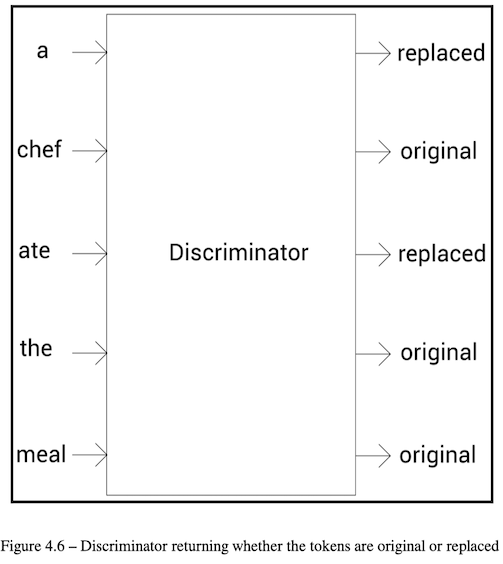

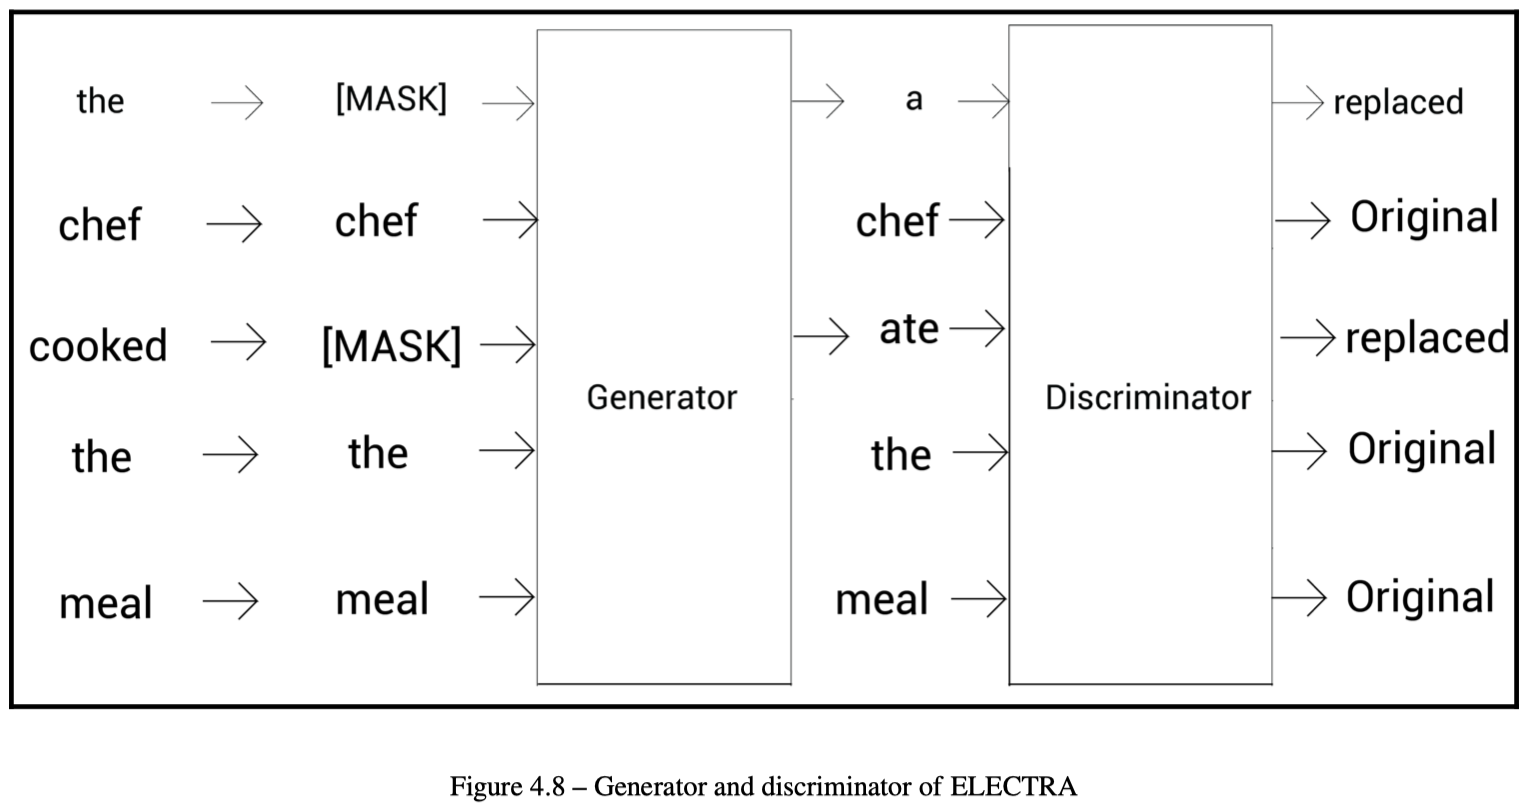

The discriminator is basically our ELECTRA model.

After training, we can remove the generator to use the discriminator as the ELECTRA model.

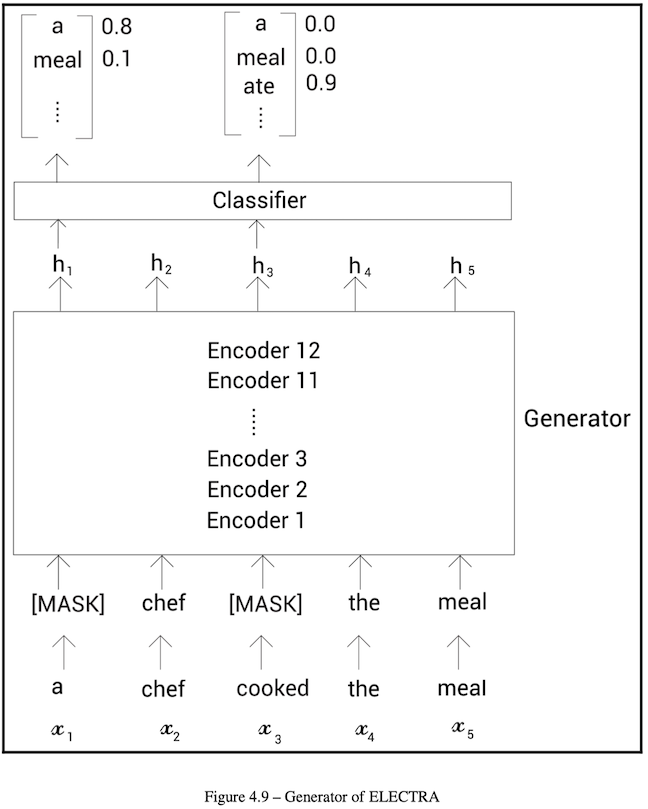

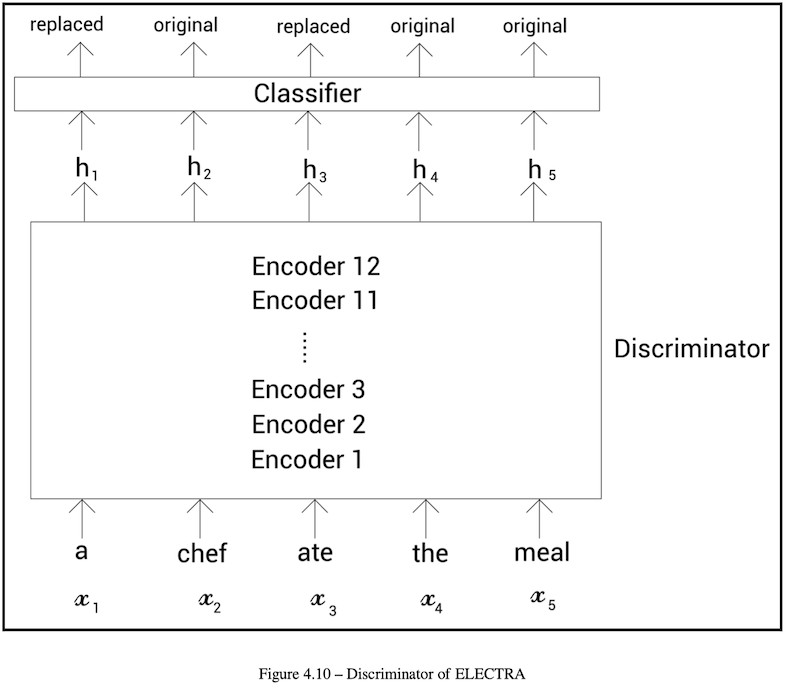

After the masked tokens being replaced by different tokens, we feed the given tokens the discriminator.

The discriminator then returns the representation of each token.

We then feed the representations to a classifier, which is basically a feedforward network with sigmoid function, to classify whether the token is replaced or original.

In [21]:
from transformers import ElectraTokenizer, ElectraModel

In [22]:
model = ElectraModel.from_pretrained('google/electra-small-discriminator')

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 4. SpanBERT

Another popular variant of BERT, SpanBERT is mostly used for tasks such as question answering where we predict the span of text.

In SpanBERT we mask a contiguous span of tokens in the sentence.

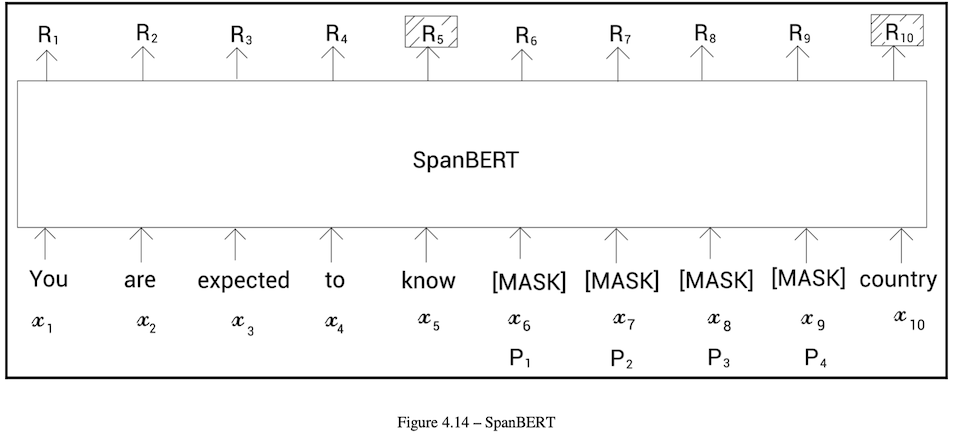

SpanBERT model uses two objectives: MLM and SBO (Span Boundary Objectives).

For SBO object tive, we try to predict tokens inside the span only with span boundary (which are R5 and R10 in the previous figure), along tiwth with the position embedding of the masked tokens.

## Performing QnAs with pre-trained SpanBERT

In [23]:
from transformers import pipeline

In [24]:
qa_pipeline = pipeline(
    "question-answering", #task we want to perform
    model = "mrm8488/spanbert-large-finetuned-squadv2",
    tokenizer = "SpanBERT/spanbert-large-cased"
)

In [25]:
results = qa_pipeline({
  'question': "What is machine learning?",
  'context': "Machine learning is a subset of artificial intelligence. It is widely for creating a variety of applications such as email filtering and computer vision"
})

In [26]:
#Let's print the result
print(results['answer'])

a subset of artificial intelligence
